# 对比多个模型结果

In [100]:
%config Completer.use_jedi = False

## 引入依赖包

In [101]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

In [102]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [103]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


## DataSet

### 数据集定义

In [104]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


## 加载数据集

In [105]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [106]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 248: 


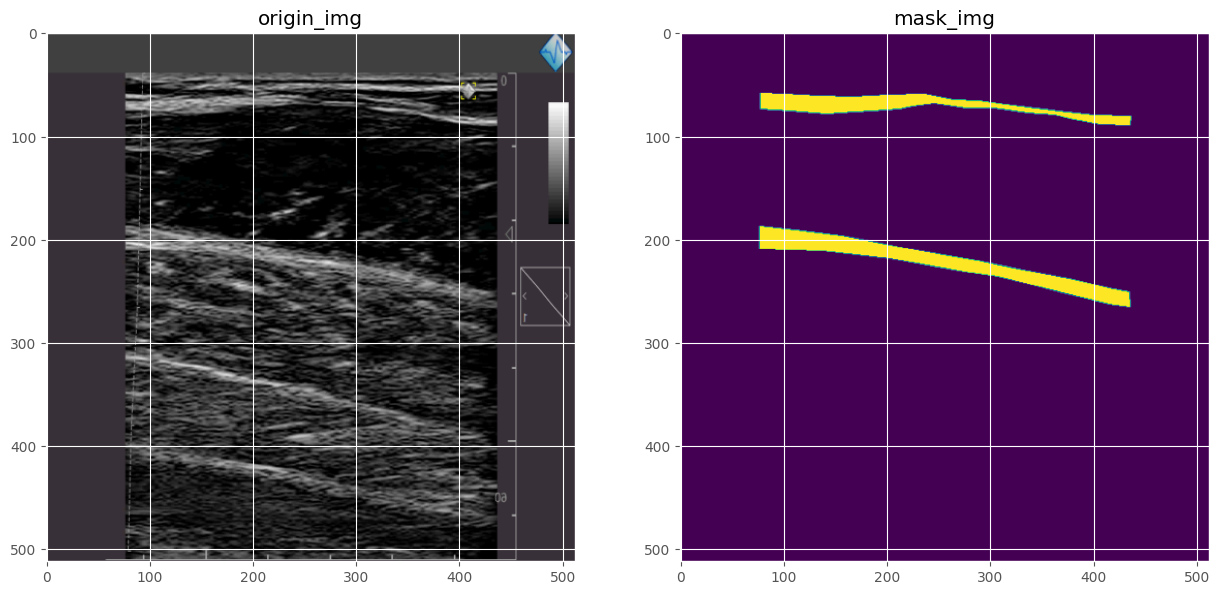

In [107]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 多种网络模型

### UNet
> https://github.com/njcronin/dl_track

In [108]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        return self.outc(x)


### UNext
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [109]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt


import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb


class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=512, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=2, embed_dims=[128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.n_classes = num_classes
        self.n_channels = input_channels
        
        self.encoder1 = nn.Conv2d(input_channels, 16, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=2, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


## Transfuse
> https://github.com/Rayicer/TransFuse

### transformer.py

In [110]:

import torch
import torch.nn as nn
from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained

from timm.models.registry import register_model
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _conv_filter(state_dict, patch_size=2):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    if pretrained:
        # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
        kwargs.setdefault('qk_scale', 768 ** -0.5)
    model = VisionTransformer(patch_size=2, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
#     model.default_cfg = default_cfgs['vit_small_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_base_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_224']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(patch_size=2, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch16_224']
    return model


@register_model
def vit_huge_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch32_384']
    return model


### DeiT.py

In [111]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial

# from .vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_
import torch.nn.functional as F
import numpy as np


__all__ = [
    'deit_tiny_patch16_224', 'deit_small_patch16_224', 'deit_base_patch16_224',
    'deit_tiny_distilled_patch16_224', 'deit_small_distilled_patch16_224',
    'deit_base_distilled_patch16_224', 'deit_base_patch16_384',
    'deit_base_distilled_patch16_384',
]


class DeiT(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))

    def forward(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        B = x.shape[0]
        x = self.patch_embed(x)
        pe = self.pos_embed

        x = x + pe
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x


@register_model
def deit_small_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=2, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_small_patch16_224-cd65a155.pth')
        model.load_state_dict(ckpt['model'], strict=False)
    
    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_224-b5f2ef4d.pth')
        model.load_state_dict(ckpt['model'], strict=False)

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_384(pretrained=False, **kwargs):
    model = DeiT(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_384-8de9b5d1.pth')
        model.load_state_dict(ckpt["model"])

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(24, 32), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model

### transfuse.py

In [112]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.models import resnet50
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import torch.nn.functional as F
import numpy as np
import math
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class BiFusion_block(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv2d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout2d(drop_rate)
        self.drop_rate = drop_rate

        
    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        bp = self.W(W_g*W_x)

        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        g = self.spatial(g)
        g = self.sigmoid(g) * g_in

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x) * x_in
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse


class TransFuse_S(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_S, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3

        self.resnet = resnet34()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet34-333f7ec4.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_small_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=384, out_ch=128)
        self.up2 = Up(128, 64)

        self.final_x = nn.Sequential(
            Conv(256, 64, 1, bn=True, relu=True),
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=256, ch_2=384, r_2=4, ch_int=256, ch_out=256, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=128, ch_2=128, r_2=2, ch_int=128, ch_out=128, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=256, out_ch=128, in_ch2=128, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=64, ch_2=64, r_2=1, ch_int=64, ch_out=64, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(128, 64, 64, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)

        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u) 

        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here

        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)
        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


class TransFuse_L(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
            
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)
        

class TransFuse_L_384(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L_384, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_384(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 24, 32)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


def init_weights(m):
    """
    Initialize weights of layers using Kaiming Normal (He et al.) as argument of "Apply" function of
    "nn.Module"
    :param m: Layer to initialize
    :return: None
    """
    if isinstance(m, nn.Conv2d):
        '''
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        trunc_normal_(m.weight, std=math.sqrt(1.0/fan_in)/.87962566103423978)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        '''
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)
        
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch1, out_ch, in_ch2=0, attn=False):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch1+in_ch2, out_ch)

        if attn:
            self.attn_block = Attention_block(in_ch1, in_ch2, out_ch)
        else:
            self.attn_block = None

    def forward(self, x1, x2=None):

        x1 = self.up(x1)
        # input is CHW
        if x2 is not None:
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

            if self.attn_block is not None:
                x2 = self.attn_block(x1, x2)
            x1 = torch.cat([x2, x1], dim=1)
        x = x1
        return self.conv(x)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.identity = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.double_conv(x)+self.identity(x))


class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

## 模型测试

In [113]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 模型训练

In [114]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


## train UNet

In [115]:
# model = UNet(n_channels=3, n_classes=1, bilinear=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

# model = model.to(memory_format=torch.channels_last)
# model.to(device)

# train(model, device, project='U-Net')


## train UNext

In [116]:
# model = UNext(input_channels=3, num_classes=1, img_size=512)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

# model = model.to(memory_format=torch.channels_last)
# model.to(device)

# train(model, device, project='U-Next')


## train transfuse

In [117]:
# model = TransFuse_S(pretrained=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

# model = model.to(memory_format=torch.channels_last)
# model.to(device)

# train(model, device, project='U-Next')


Epoch 1/60:   0%|          | 0/456 [00:00<?, ?img/s]


RuntimeError: The size of tensor a (65536) must match the size of tensor b (192) at non-singleton dimension 1